# Imports

In [1]:
import pandas as pd
from tqdm import tqdm
import wandb
wandb.login()
api = wandb.Api(timeout=100)

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['figure.figsize'] = (6.0, 3.0)

wandb: Currently logged in as: dustins (allennlp). Use `wandb login --relogin` to force relogin


In [39]:
def make_standard_fig(fig_plt, fig_labels=None, save = False, outfile='fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=20, verticalalignment='bottom', color=label_color)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=15, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=15, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=12)
    plt.tick_params(axis='y', which='major', labelsize=12)
    if save:
        plt.savefig(outfile, bbox_inches='tight', transparent=False)

In [3]:
def make_standard_fig_small(fig_plt, fig_labels=None, save = False, outfile='fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=30, verticalalignment='bottom', color=label_color)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=10, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=10, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=10)
    plt.tick_params(axis='y', which='major', labelsize=10)
    if save:
        plt.savefig(outfile, bbox_inches='tight', transparent=False)

In [4]:
def build_single_run_df(run, keys=["_step", "optim/total_grad_norm"]):
    aoh_p = run.scan_history(keys)
    run_df = pd.DataFrame([row for row in tqdm(aoh_p)])
    return run_df


def build_run_df(group, project="ai2-llm/olmo-medium", keys=["_step", "optim/total_grad_norm"]):
    run_group = api.runs(project, filters={"group": group})
    run_dfs = []
    for run in run_group.objects:
        print(f'fetching {run}')
        rdf = build_single_run_df(run, keys)
        if not rdf.empty:
            run_dfs.append(rdf)
    return pd.concat(run_dfs)

In [5]:
def trim_df(df, start_step, end_step):
    trimmed_df = df[(df['_step'] >= start_step) & (df['_step'] <= end_step)]
    return trimmed_df


def prep_df_for_ss(df, start_step=None, end_step=None):
    targ_df = trim_df(df, start_step, end_step)
    targ_df = targ_df.drop_duplicates('_step').sort_values('_step')
    targ_df.index = targ_df['_step']
    return targ_df


def zscore(metric_series, window, thresh):
    rolling_win = metric_series.rolling(window=window, min_periods=10, center=True)
    avg = rolling_win.mean()
    std = rolling_win.std(ddof=0)
    z = metric_series.sub(avg).div(std)   
    outliers = ~z.between(-thresh, thresh)
    return z, avg, std, outliers


def spike_score(df, metric='optim/total_grad_norm', window=1000, thresh=5):
    z, avg, std, outliers = zscore(df[metric], window, thresh)
    n_outliers = outliers.sum()
    return n_outliers / df.shape[0] * 100

# fast and slow spikes

In [ ]:
fig_labels = {
    'x_label': 'Train step',
    'y_label': 'Log gradient norm'
}

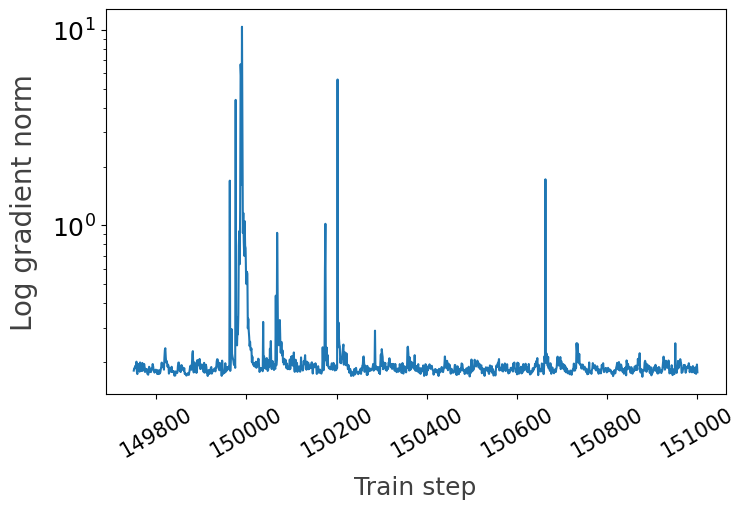

In [619]:
prep_df_for_ss(llamaish_7_df, 149750, 151000)['optim/total_grad_norm'].plot(logy=True)
plt.xticks(rotation=30)
make_standard_fig_small(_, fig_labels, save=True, outfile='slow_vs_fast_spike.pdf')

In [579]:
amberish_7_df_pfss = prep_df_for_ss(amberish_7_df, start_step=start_step, end_step=end_step)
llamaish_7_df_pfss = prep_df_for_ss(llamaish_7_df, start_step=start_step, end_step=end_step)
mitchish_7_df_pfss = prep_df_for_ss(mitchish_7_df, start_step=start_step, end_step=end_step)

In [580]:
amberish_ss = spike_score(amberish_7_df_pfss, 'optim/total_grad_norm')
llamaish_ss = spike_score(llamaish_7_df_pfss, 'optim/total_grad_norm')
mitchish_ss = spike_score(mitchish_7_df_pfss, 'optim/total_grad_norm')

In [581]:
ss_res_df = pd.DataFrame(pd.Series({'amberish': amberish_ss, 'mitchish': mitchish_ss, 'llamaish_ss': llamaish_ss}))
ss_res_df.columns = ['SpikeScore™']

In [582]:
ss_res_df.round(2).sort_values('SpikeScore™')

,SpikeScore™
amberish,0.18
llamaish_ss,0.27
mitchish,0.42


# Amber comparisons

In [343]:
fit_portion = deepcopy(amber7_official_full_df[amber7_official_full_df._step < 15000])
fit_portion['scaled_step'] = fit_portion['_step']

In [353]:
amber7_baseline3_df['scaled_step'] = amber7_baseline3_df['_step']

In [344]:
combined_df = pd.merge(fit_portion, amber7_repro_df, left_on='scaled_step', right_on='scaled_step')

In [348]:
amber7_baseline3_df['amber_repro_grad_norm'] = amber7_baseline3_df['optim/total_grad_norm']

In [354]:
combined_df_1 = pd.merge(combined_df, amber7_baseline3_df, left_on='scaled_step', right_on='scaled_step')

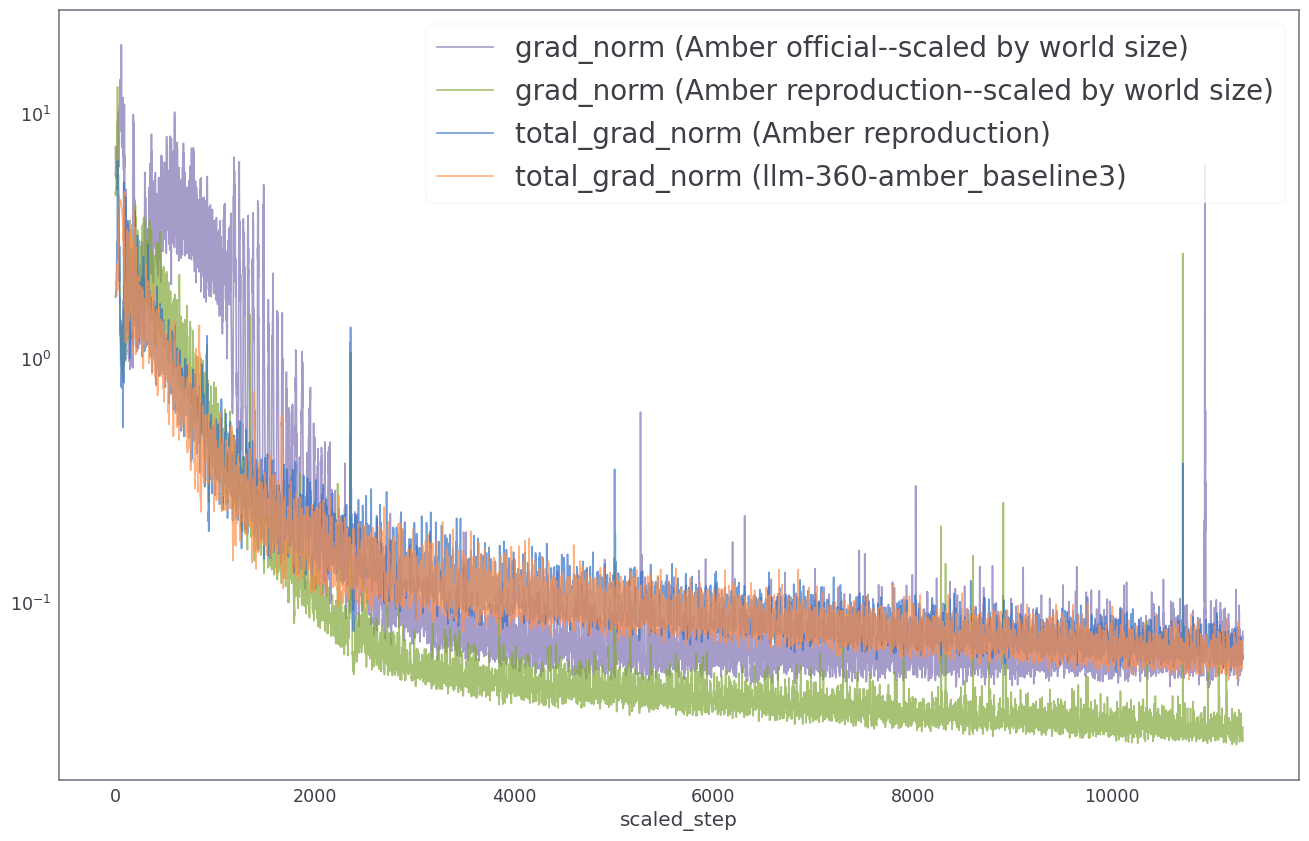

In [410]:
_ = combined_df_1.plot(x='scaled_step', y=['optim/total_grad_norm_x', 'scaled_grad_norm', 'total_grad_norm', 'amber_repro_grad_norm'], logy=True, alpha=0.7, color=['C3', 'C1', 'b', 'y'])
_ = plt.legend(['grad_norm (Amber official--scaled by world size)', 'grad_norm (Amber reproduction--scaled by world size)', 'total_grad_norm (Amber reproduction)', 'total_grad_norm (llm-360-amber_baseline3)'], fontsize=20)

# Data filter comparison

In [21]:
llamaish7_ndf_df  = build_run_df('llamaish7-dirk-baseline-normal-init')

fetching <Run ai2-llm/olmo-medium/6ta6siat (crashed)>


In [22]:
llamaish7_df_df  = build_run_df('llamaish7-dirk-baseline-normal-init-data-fix')

fetching <Run ai2-llm/olmo-medium/cfto4ur4 (crashed)>


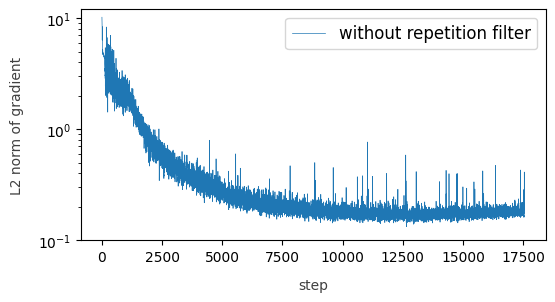

In [217]:
fp = llamaish7_ndf_df[:17500].plot(x='_step', y=['optim/total_grad_norm'], logy=True, linewidth=0.5)
_ = plt.legend(['without repetition filter'], prop={'size': 10})
fig_labels = {
    'y_label': 'L2 norm of gradient', 
    'x_label': 'step'
}
plt.ylim(.1, 12)
_ = plt.legend(['without repetition filter'], prop={'size': 12})
make_standard_fig_small(fp, fig_labels=fig_labels, save=True, outfile='without_data_filter_gnorm.pdf')

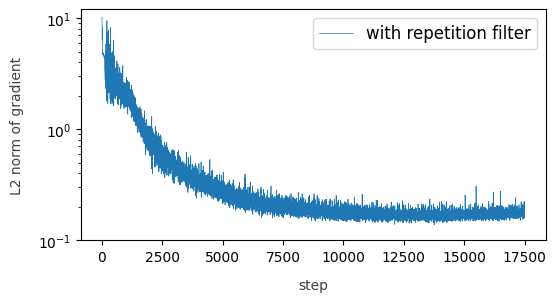

In [218]:
fp = llamaish7_df_df[:17500].plot(x='_step', y=['optim/total_grad_norm'], logy=True, linewidth=0.5)
_ = plt.legend(['with repetition filter'], prop={'size': 12})
plt.ylim(.1, 12)
make_standard_fig_small(fp, fig_labels=fig_labels, save=True, outfile='with_data_filter_gnorm.pdf')

## spike score

In [36]:
prep_df_for_ss(llamaish7_ndf_df, 0, 20000)

,_step,optim/total_grad_norm
_step,,
1,1,10.188335
2,2,10.035199
3,3,9.837146
4,4,9.819026
5,5,9.873960
...,...,...
19094,19094,0.180361
19095,19095,0.179081
19096,19096,0.183192


In [37]:
start_step, end_step = 0, 20000
llamaish7_ndf_ss = spike_score(prep_df_for_ss(llamaish7_ndf_df, 0, 20000), 'optim/total_grad_norm')
llamaish7_df_ss = spike_score(prep_df_for_ss(`llamaish7_df_df, 0, 20000), 'optim/total_grad_norm')

In [38]:
llamaish7_ndf_ss, llamaish7_df_ss

(0.2468487394957983, 0.06999999999999999)

## combined figs

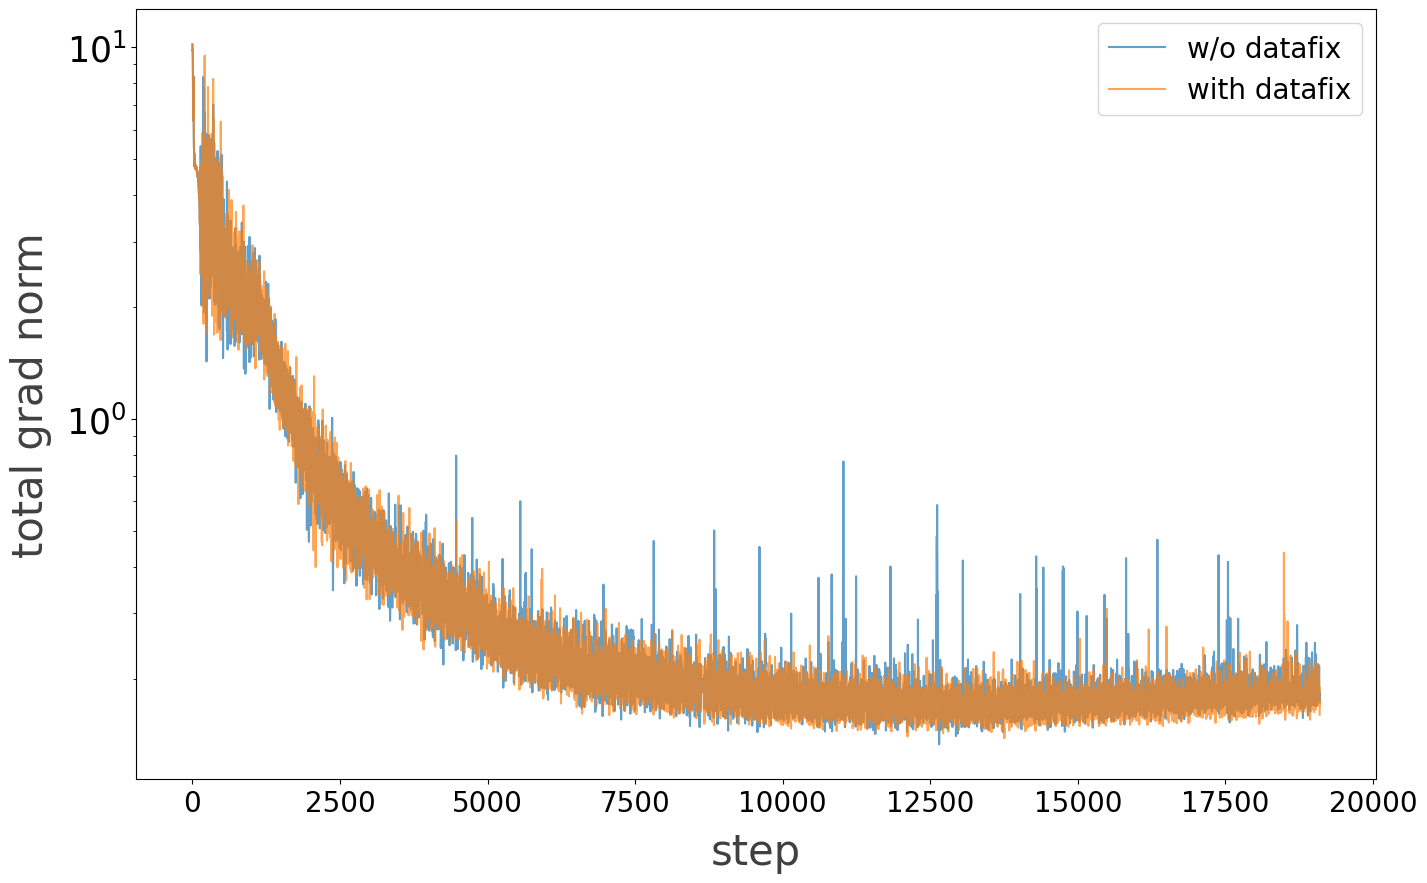

In [218]:
fp = combined_llamaish7_df.plot(x='_step', y=['optim/total_grad_norm_x', 'optim/total_grad_norm_y'], logy=True, alpha=0.7,)
fig_labels = {
    'y_label': 'total grad norm', 
    'x_label': 'step'
}

# plt.ylabel(fig_labels['y_label'], fontsize=30, labelpad=10, color=label_color)

_ = plt.legend(['w/o datafix', 'with datafix'], prop={'size': 20})
make_standard_fig(fp, fig_labels=fig_labels)

In [280]:
ss_res_df = pd.DataFrame(pd.Series({'With data-fix': wdf_ss, 'Without data-fix': wodf_nss}))
ss_res_df.columns = ['SpikeScore™']

In [281]:
ss_res_df

,SpikeScore™
With data-fix,0.021053
Without data-fix,0.163158


## combined figure 2

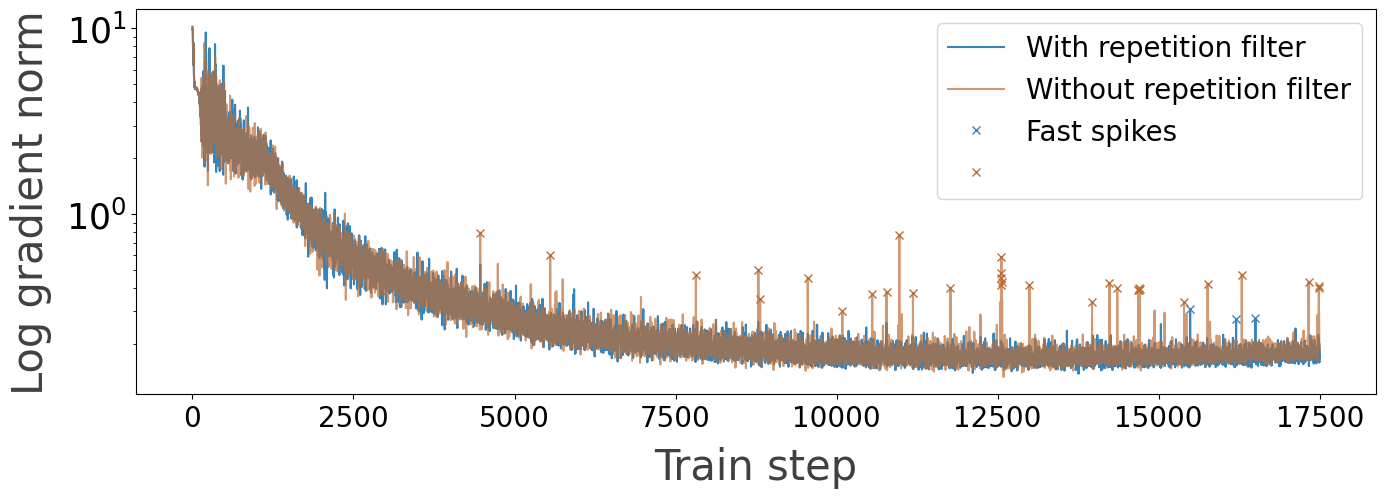

In [405]:
targ_df = llamaish7_df_df[:17500]
z, avg, std, m = zscore(targ_df['optim/total_grad_norm'], window=t_window, thresh=t_thresh)

ax = plt.subplot()

targ_df['optim/total_grad_norm'].plot(logy=True, alpha=0.9, label='With repetition filter')
# avg.plot(label='mean')
# avg[~m].plot(label='replacement', marker='o', ls='')

targ_df_1 = llamaish7_ndf_df[:17500]
z1, avg1, std1, m1 = zscore(targ_df_1['optim/total_grad_norm'], window=t_window, thresh=t_thresh)

targ_df_1['optim/total_grad_norm'].plot(logy=True, alpha=0.7, color='#bc6e37', label='Without repetition filter')
# avg.plot(label='mean')
targ_df.loc[m, 'optim/total_grad_norm'].plot(label='Fast spikes', marker='x', ls='', logy=True, color='#3785bc')
targ_df_1.loc[m1, 'optim/total_grad_norm'].plot(label=' ', marker='x', ls='', logy=True, color='#bc6e37')


plt.legend(prop={'size': 20})
fig_labels = {
    'x_label': 'Train step',
    'y_label': 'Log gradient norm'
}
make_standard_fig(_, fig_labels, save=True, outfile='data_filter_example.pdf')

## spike score vis

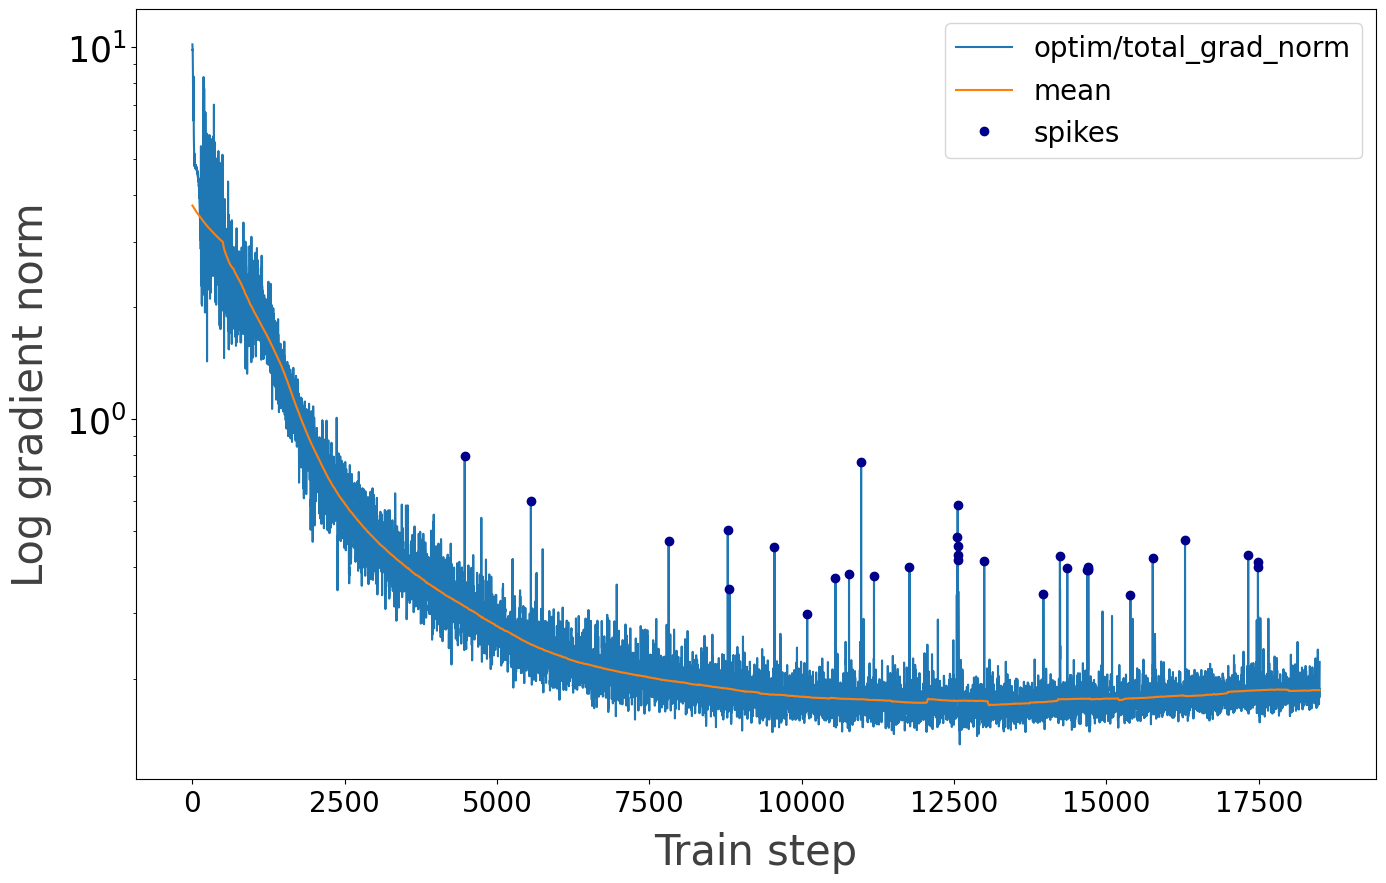

In [339]:
targ_df_1 = llamaish7_ndf_df[:18500]
z, avg, std, m = zscore(targ_df_1['optim/total_grad_norm'], window=t_window, thresh=t_thresh)

ax = plt.subplot()

targ_df_1['optim/total_grad_norm'].plot(logy=True)
avg.plot(label='mean')
targ_df_1.loc[m, 'optim/total_grad_norm'].plot(label='spikes', marker='o', ls='', logy=True, color='darkblue')
# avg[~m].plot(label='replacement', marker='o', ls='')
plt.legend(prop={'size': 20})
make_standard_fig(_ ,fig_labels)

# WD on embeddings

In [177]:
amberish_1  = build_run_df('amberish1', project="ai2-llm/olmo-small", keys=["_step", "optim/total_grad_norm", 'optim/param/transformer.wte.weight.norm'])

fetching <Run ai2-llm/olmo-small/6l9vfw5n (finished)>


149650it [00:53, 2806.84it/s]


fetching <Run ai2-llm/olmo-small/evp1r3b1 (finished)>


130260it [01:39, 1304.51it/s]


In [176]:
# amberish_1.to_pickle('./amber_1_wandb_res.pkl')

In [166]:
amberish_1_wd  = build_run_df('amberish1-wd-all', project="ai2-llm/olmo-small", keys=["_step", "optim/total_grad_norm", 'optim/param/transformer.wte.weight.norm'])

fetching <Run ai2-llm/olmo-small/ojjxk7ls (finished)>


145766it [00:54, 2670.73it/s]


fetching <Run ai2-llm/olmo-small/i6sflnkw (finished)>


177552it [01:59, 1488.79it/s]


In [179]:
amberish_1_trimmed = prep_df_for_ss(amberish_1, 0, 323460)

In [180]:
combined_amberish1_df = pd.merge(amberish_1_trimmed.reset_index(drop=True), amberish_1_wd, left_on='_step', right_on='_step')

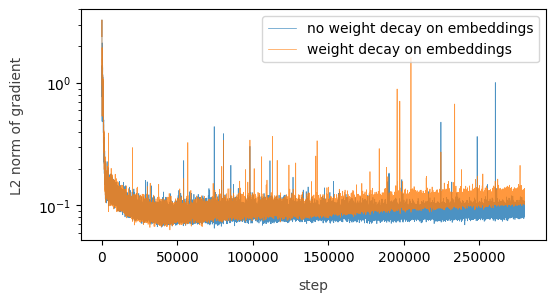

In [227]:
fp = combined_amberish1_df[::10].plot(x='_step', y=['optim/total_grad_norm_x', 'optim/total_grad_norm_y'], logy=True, linewidth=0.5, alpha=0.8)
fig_labels = {
    'y_label': 'L2 norm of gradient', 
    'x_label': 'step'
}


_ = plt.legend(['no weight decay on embeddings', 'weight decay on embeddings'], prop={'size': 10})
make_standard_fig_small(fp, fig_labels=fig_labels, save=True, outfile='embedding_wd_comp.pdf')

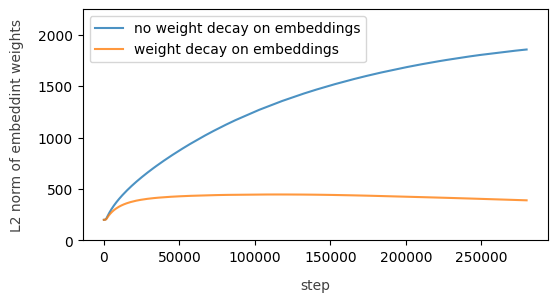

In [226]:
fp = combined_amberish1_df.plot(x='_step', y=['optim/param/transformer.wte.weight.norm_x', 'optim/param/transformer.wte.weight.norm_y'], linewidth=1.5, alpha=0.8)
fig_labels = {
    'y_label': 'L2 norm of embeddint weights', 
    'x_label': 'step'
}

plt.ylim(0, 2250)
_ = plt.legend(['no weight decay on embeddings', 'weight decay on embeddings'], prop={'size': 10}, loc='upper left')
make_standard_fig_small(fp, fig_labels=fig_labels, save=True, outfile='embedding_wd_comp_emb_norm.pdf')

In [93]:
no_wd = spike_score(amberish_1_trimmed, 'optim/total_grad_norm')
yes_wd = spike_score(amberish_1_wd, 'optim/total_grad_norm')

In [229]:
no_wd.round(3), yes_wd.round(3)

(0.092, 0.16)

# Learning rates

In [155]:
lr_groups = [
    'peteish7-medlr-from72000-100e9',
    'peteish7-xhighlr-from72000-100e9',
    'peteish7-highlr-from72000-100e9',
    'peteish7-xhighlr-from72000',
    'peteish7-lowlr-from72000',
    'peteish7-medlr-from72000',
    'peteish7-highlr-from72000'
]

lr_lookup = {
    'peteish7-medlr-from72000-100e9': '6e-4 peak LR @ 100B tokens',
    'peteish7-xhighlr-from72000-100e9': '12e-4 peak LR @ 100B tokens',
    'peteish7-highlr-from72000-100e9': '9e-4 peak LR @ 100B tokens',
    'peteish7-xhighlr-from72000': '12e-4 peak LR @ 50B tokens',
    'peteish7-lowlr-from72000': '3e-4 peak LR @ 50B tokens',
    'peteish7-medlr-from72000': '6e-4 peak LR @ 50B tokens',
    'peteish7-highlr-from72000': '9e-4 peak LR @ 50B tokens'
}

## metrics

In [172]:
olmes_core_9 = ['eval/downstream/arc_challenge_len_norm',
 'eval/downstream/arc_easy_acc',
 'eval/downstream/boolq_acc',
 'eval/downstream/commonsense_qa_len_norm',
 'eval/downstream/hellaswag_len_norm',
 'eval/downstream/openbook_qa_len_norm',
 'eval/downstream/piqa_len_norm',
 'eval/downstream/social_iqa_len_norm',
 'eval/downstream/winogrande_acc']


olmes_core_12 = ['eval/downstream/arc_challenge_len_norm',
 'eval/downstream/arc_easy_acc',
 'eval/downstream/basic_arithmetic_acc',
 'eval/downstream/boolq_acc',
 'eval/downstream/commonsense_qa_len_norm',
 'eval/downstream/copa_acc',
 'eval/downstream/hellaswag_len_norm',
 'eval/downstream/openbook_qa_len_norm',
 'eval/downstream/piqa_len_norm',
 'eval/downstream/sciq_acc',
 'eval/downstream/social_iqa_len_norm',
 'eval/downstream/winogrande_acc',
]

mmlu_keys = ['eval/downstream/mmlu_humanities_mc_5shot_len_norm',
 'eval/downstream/mmlu_other_mc_5shot_len_norm',
 'eval/downstream/mmlu_social_sciences_mc_5shot_len_norm',
 'eval/downstream/mmlu_stem_mc_5shot_len_norm']

In [171]:
mmlu_keys

['eval/downstream/mmlu_humanities_mc_5shot_len_norm',
 'eval/downstream/mmlu_other_mc_5shot_len_norm',
 'eval/downstream/mmlu_social_sciences_mc_5shot_len_norm',
 'eval/downstream/mmlu_stem_mc_5shot_len_norm']

In [157]:
def build_run_df_samples(group, project="ai2-llm/olmo-medium", keys=["_step", "optim/total_grad_norm"]):
    run_group = api.runs(project, filters={"group": group})
    res_df = run_group.histories(samples=1000, keys=['train/CrossEntropyLoss', 'throughput/total_tokens'], format="pandas").sort_values('_step')
    return res_df

In [195]:
def mmlu_wa(mmlu_scores):
    avg_score = 0.215 * mmlu_scores['mmlu_stem_mc_5shot_len_norm'] \
    + 0.335 * mmlu_scores['mmlu_humanities_mc_5shot_len_norm'] \
    + 0.219 * mmlu_scores['mmlu_social_sciences_mc_5shot_len_norm'] \
    + 0.231 * mmlu_scores['mmlu_other_mc_5shot_len_norm']
    return avg_score


def build_run_metric_df(group, project="ai2-llm/olmo-medium"):
    run_group = api.runs(project, filters={"group": group})
    trmsr = run_group.objects[-1].summary
    core_9_scores= pd.Series({k.split('/')[-1]: trmsr[k] for k in olmes_core_9}).mean()
    core_12_scores= pd.Series({k.split('/')[-1]: trmsr[k] for k in olmes_core_12}).mean()
    mmlu_scores= mmlu_wa({k.split('/')[-1]: trmsr[k] for k in mmlu_keys})
    scores = {'olmes_core_9': core_9_scores, 
              'olmes_core_12': core_12_scores,
              'mmlu': mmlu_scores}
    return scores

In [196]:
lr_metrics_res = {lr_lookup[g]: build_run_metric_df(g, project="ai2-llm/olmo-medium") for g in lr_groups}
metric_res_df = pd.DataFrame(lr_metrics_res).round(3)
metric_res_df.T

,olmes_core_9,olmes_core_12,mmlu
6e-4 peak LR @ 100B tokens,0.646,0.697,0.488
12e-4 peak LR @ 100B tokens,0.642,0.690,0.499
9e-4 peak LR @ 100B tokens,0.645,0.692,0.500
12e-4 peak LR @ 50B tokens,0.636,0.686,0.466
3e-4 peak LR @ 50B tokens,0.625,0.667,0.458
6e-4 peak LR @ 50B tokens,0.639,0.688,0.482
9e-4 peak LR @ 50B tokens,0.641,0.688,0.468


### build eval keys

In [173]:
# trmsr = build_run_metric_df(lr_groups[0], project="ai2-llm/olmo-medium")

# # eval_keys = [k for k in trmsr.keys() if 'eval' in k]
# mmlu_keys = [k for k in trmsr.keys() if 'mmlu' in k and '5shot_len_norm' in k]
# # nonmmlu_keys = [k for k in eval_keys if 'mmlu' not in k]

## loss curves

In [508]:
lr_run_dfs = {g: build_run_df_samples(g, project="ai2-llm/olmo-medium", keys=["_step", "train/CrossEntropyLoss", "throughput/total_tokens"]) for g in lr_groups}

In [509]:
lr_run_dfs_full = {}

In [512]:
for g in lr_groups:
    try:
        rd = build_run_df(g, project="ai2-llm/olmo-medium", keys=["_step", "train/CrossEntropyLoss", "throughput/total_tokens"])
        lr_run_dfs_full[g] = rd
    except:
        pass

fetching <Run ai2-llm/olmo-medium/x4ks1a2y (failed)>


0it [00:00, ?it/s]


fetching <Run ai2-llm/olmo-medium/nsigw780 (failed)>


0it [00:00, ?it/s]


fetching <Run ai2-llm/olmo-medium/udukzeik (crashed)>


334it [00:24, 13.38it/s]


fetching <Run ai2-llm/olmo-medium/68ksgbaf (crashed)>


15473it [00:28, 538.92it/s] 


fetching <Run ai2-llm/olmo-medium/w251q1k7 (crashed)>


6338it [00:32, 197.31it/s]


fetching <Run ai2-llm/olmo-medium/0u1rldvl (finished)>


2852it [00:31, 89.18it/s] 


fetching <Run ai2-llm/olmo-medium/yilcu4yl (finished)>


23852it [00:32, 742.25it/s] 


fetching <Run ai2-llm/olmo-medium/vc21d025 (finished)>


23852it [00:32, 725.14it/s] 


fetching <Run ai2-llm/olmo-medium/i1gy0n5g (finished)>


11931it [00:30, 393.13it/s] 


fetching <Run ai2-llm/olmo-medium/1i8oo3l0 (finished)>


0it [00:08, ?it/s]


fetching <Run ai2-llm/olmo-medium/iy7x0gy0 (finished)>


0it [00:02, ?it/s]


fetching <Run ai2-llm/olmo-medium/kt0zhdxq (crashed)>


0it [00:00, ?it/s]


In [402]:
import seaborn as sns

<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
/var/folders/89/qnfd36sx1rs246whpmhw3gh00000gq/T/ipykernel_78106/2182519522.py:9: SyntaxWarning: invalid escape sequence '\c'
  df.plot(x="_step", y="smooth_cel", ax=ax, label= r'{}'.format(lr_lookup[lr_group].replace('e-4', '$\cdot10^{-4}$')), figsize=(10, 6), linewidth=1, alpha=0.8)


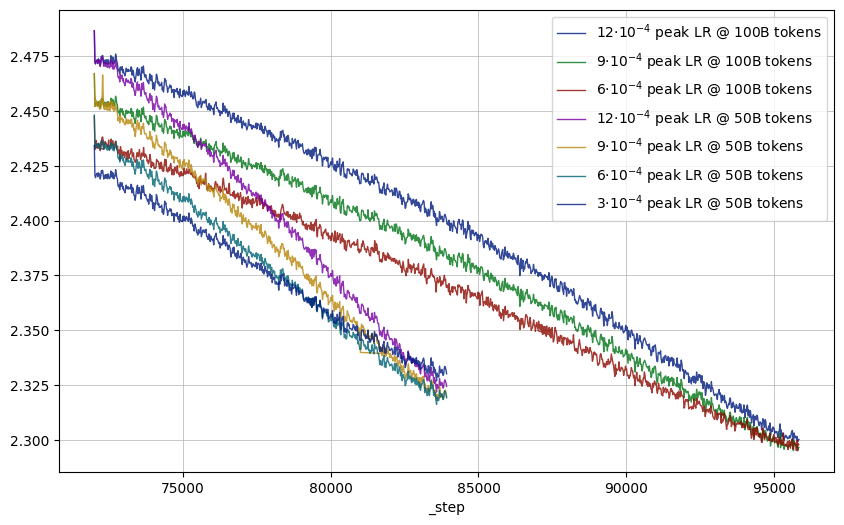

In [507]:
fig, ax = plt.subplots()


ax.set_prop_cycle('color', sns.color_palette(n_colors = 7))

for lr_group, df in sorted(sorted(lr_run_dfs_full.items(), key=lambda x: float(lr_lookup[x[0]].split(' ')[0]), reverse=True), key=lambda x: (lr_lookup[x[0]].split('@ ')[1])):
    df['smooth_cel'] = df['train/CrossEntropyLoss'].ewm(alpha=.05).mean()
    df = df[::20]
    df.plot(x="_step", y="smooth_cel", ax=ax, label= r'{}'.format(lr_lookup[lr_group].replace('e-4', '$\cdot10^{-4}$')), figsize=(10, 6), linewidth=1, alpha=0.8)

plt.grid(True)

In [662]:
regular_runs = [
    "peteish7-xhighlr",
    "peteish7-highlr",
    "peteish7-medlr",
    "peteish7-lowlr",
]
anneal_50b = [x + "-from72000" for x in regular_runs]
anneal_100b = [x + "-from72000-100e9" for x in regular_runs if x != "peteish7-lowlr"]
regular_runs[regular_runs.index("peteish7-lowlr")] = "peteish7"
wandb_groups = regular_runs + anneal_50b + anneal_100b

min_step = 65000

metric_names = ["train/CrossEntropyLoss"]
metrics = {
    (group, name): {}
    for name in metric_names
    for group in wandb_groups
}
for wandb_group in wandb_groups:
    runs = api.runs(f"ai2-llm/olmo-medium", filters={"group": wandb_group}, order="created_at")
    if wandb_group in regular_runs:
        max_step = 72000
    else:
        max_step = None
    for run in tqdm(runs):
        for data in run.scan_history(keys=["_step"] + metric_names, page_size=10000, min_step=min_step, max_step=max_step):
            step = int(data["_step"])
            for metric_name in metric_names:
                value = data[metric_name]
                if value is not None:
                    metrics[(wandb_group, metric_name)][step] = data[metric_name]

100%|████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]


In [665]:
# postprocess
for key, d in metrics.items():
    metrics[key] = {
        step * 1024 * 4096 : value
        for step, value in sorted(d.items())
    }

In [679]:
metric_dfs_2 = {run[0]: pd.DataFrame(pd.Series(m)) for run, m in metrics.items()}

In [685]:
lr_lookup_2 = {
    'peteish7-medlr-from72000-100e9': '6e-4 peak LR @ 100B tokens',
    'peteish7-xhighlr-from72000-100e9': '12e-4 peak LR @ 100B tokens',
    'peteish7-highlr-from72000-100e9': '9e-4 peak LR @ 100B tokens',
    'peteish7-xhighlr-from72000': '12e-4 peak LR @ 50B tokens',
    'peteish7-lowlr-from72000': '3e-4 peak LR @ 50B tokens',
    'peteish7-medlr-from72000': '6e-4 peak LR @ 50B tokens',
    'peteish7-highlr-from72000': '9e-4 peak LR @ 50B tokens',
    'peteish7-xhighlr': '12e-4 peak LR',
}

<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
/var/folders/89/qnfd36sx1rs246whpmhw3gh00000gq/T/ipykernel_78106/3055777523.py:19: SyntaxWarning: invalid escape sequence '\c'
  plt.legend(["lr = $12 \cdot 10^{-4}$", "lr = $9 \cdot 10^{-4}$", "lr = $6 \cdot 10^{-4}$", "lr = $3 \cdot 10^{-4}$"], prop={'size': 16})
/var/folders/89/qnfd36sx1rs246whpmhw3gh00000gq/T/ipykernel_78106/3055777523.py:19: SyntaxWarning: invalid escape sequence '\c'
  plt.legend(["lr = $12 \cdot 10^{-4}$", "lr = $9 \cdot 10^{-4}$", "lr = $6 \cdot 10^{-4}$", "lr = $3 \cdot 10^{-4}$"], prop={'size': 16})
/var/folders/89/qnfd36sx1rs246whpmhw3gh00000gq/T/ipykernel_7

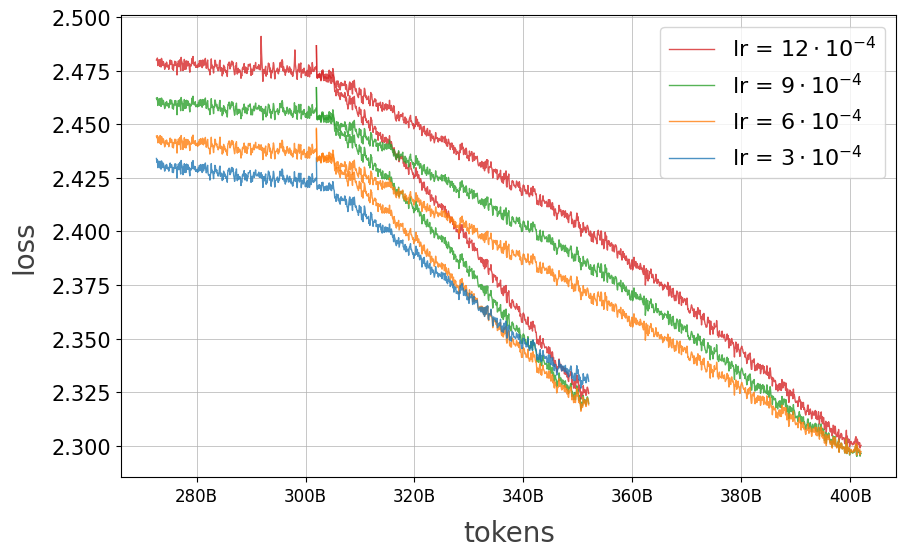

In [731]:
fig, ax = plt.subplots()


ax.set_prop_cycle('color', sns.color_palette(n_colors = 7))

for lr_group, df in metric_dfs_2.items():
    df['btokes'] = df.index / 10 **9
    df['smooth_cel'] = df[0].ewm(alpha=.05).mean()
    df = df[::20]
    if lr_group.startswith("peteish7-xhighlr"):
        color = (0.839, 0.153, 0.157)
    elif lr_group.startswith("peteish7-highlr"):
        color = (0.173, 0.627, 0.173)
    elif lr_group.startswith("peteish7-medlr"):
        color =(1.000, 0.498, 0.055) # orange
    else:
        color = (0.121, 0.466, 0.705) # blue
    df.plot(y="smooth_cel", ax=ax, figsize=(10, 6), linewidth=1, alpha=0.8, color=color)
plt.legend(["lr = $12 \cdot 10^{-4}$", "lr = $9 \cdot 10^{-4}$", "lr = $6 \cdot 10^{-4}$", "lr = $3 \cdot 10^{-4}$"], prop={'size': 16})
plt.grid(True)

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x/1e9:.0f}B"))

fig_labels = {
    'y_label': 'loss', 
    'x_label': 'tokens'
}

# plt.ylim(2.25, 2.5)
# _ = plt.legend(['no weight decay on embeddings', 'weight decay on embeddings'], prop={'size': 10}, loc='upper left')
make_standard_fig(fp, fig_labels=fig_labels, save=True, outfile='learningrateanneals.pdf')

In [702]:
wandb_groups = [
    "peteish7-xhighlr",
    "peteish7-highlr",
    "peteish7-medlr",
    "peteish7",
]
metric_names = ["train/CrossEntropyLoss"]
metrics = {
    (group, name): {}
    for name in metric_names
    for group in wandb_groups
}
max_step = None
for wandb_group in wandb_groups:
    runs = api.runs(f"ai2-llm/olmo-medium", filters={"group": wandb_group}, order="created_at")
    group_max_step = 0
    for run in tqdm(runs):
        for data in run.scan_history(keys=["_step"] + metric_names, page_size=10000, max_step=max_step):
            step = int(data["_step"])
            group_max_step = max(group_max_step, step)
            for metric_name in metric_names:
                value = data[metric_name]
                if value is not None:
                    metrics[(wandb_group, metric_name)][step] = data[metric_name]
    max_step = group_max_step if max_step is None else min(max_step, group_max_step)
    del group_max_step

100%|██████████████████████████████████████████████████████████| 19/19 [00:33<00:00,  1.75s/it]


In [703]:
# postprocess
for key, d in metrics.items():
    metrics[key] = {
        step * 1024 * 4096 : value
        for step, value in sorted(d.items())
        if step <= max_step
    }

In [704]:
metric_dfs_3 = {run[0]: pd.DataFrame(pd.Series(m)) for run, m in metrics.items()}

<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
/var/folders/89/qnfd36sx1rs246whpmhw3gh00000gq/T/ipykernel_78106/1388197151.py:19: SyntaxWarning: invalid escape sequence '\c'
  plt.legend(["lr = $12 \cdot 10^{-4}$", "lr = $9 \cdot 10^{-4}$", "lr = $6 \cdot 10^{-4}$", "lr = $3 \cdot 10^{-4}$"], prop={'size': 16})
/var/folders/89/qnfd36sx1rs246whpmhw3gh00000gq/T/ipykernel_78106/1388197151.py:19: SyntaxWarning: invalid escape sequence '\c'
  plt.legend(["lr = $12 \cdot 10^{-4}$", "lr = $9 \cdot 10^{-4}$", "lr = $6 \cdot 10^{-4}$", "lr = $3 \cdot 10^{-4}$"], prop={'size': 16})
/var/folders/89/qnfd36sx1rs246whpmhw3gh00000gq/T/ipykernel_7

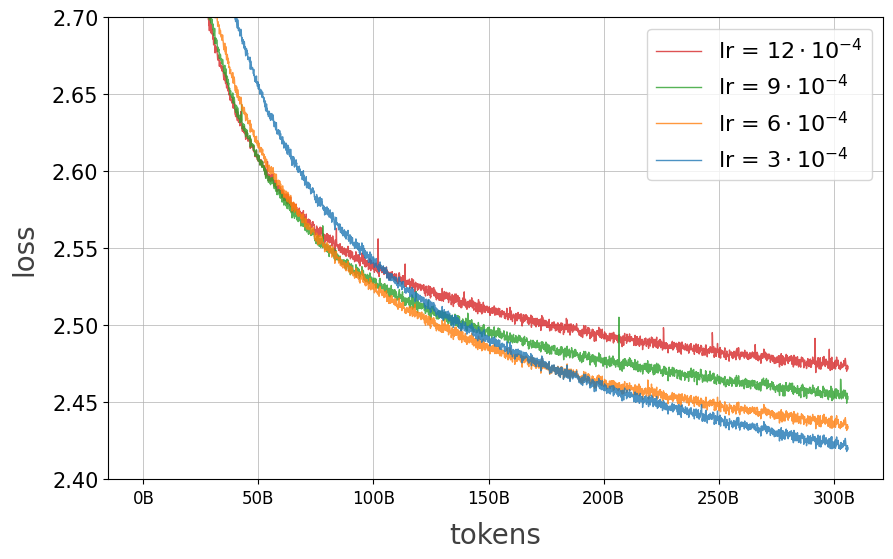

In [730]:
fig, ax = plt.subplots()


ax.set_prop_cycle('color', sns.color_palette(n_colors = 7))

for lr_group, df in metric_dfs_3.items():
    df['btokes'] = df.index / 10 **9
    df['smooth_cel'] = df[0].ewm(alpha=.05).mean()
    df = df[::20]
    if lr_group.startswith("peteish7-xhighlr"):
        color = (0.839, 0.153, 0.157)
    elif lr_group.startswith("peteish7-highlr"):
        color = (0.173, 0.627, 0.173)
    elif lr_group.startswith("peteish7-medlr"):
        color =(1.000, 0.498, 0.055) # orange
    else:
        color = (0.121, 0.466, 0.705) # blue
    df.plot(y="smooth_cel", ax=ax, figsize=(10, 6), linewidth=1, alpha=0.8, color=color)
plt.legend(["lr = $12 \cdot 10^{-4}$", "lr = $9 \cdot 10^{-4}$", "lr = $6 \cdot 10^{-4}$", "lr = $3 \cdot 10^{-4}$"], prop={'size': 16})
plt.grid(True)

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x/1e9:.0f}B"))

fig_labels = {
    'y_label': 'loss', 
    'x_label': 'tokens'
}
plt.ylim(2.4, 2.7)
# _ = plt.legend(['no weight decay on embeddings', 'weight decay on embeddings'], prop={'size': 10}, loc='upper left')
make_standard_fig(fp, fig_labels=fig_labels, save=True, outfile='learningrates.pdf')

# OG spikes

In [6]:
def builf_dir_df(run, min_step=2600, max_step=3500):
    run = api.run(f"ai2-llm/olmo-medium/{run}")
    steps = []
    values = []
    for data in tqdm(run.scan_history(keys=["_step", "train/CrossEntropyLoss"], min_step=min_step, max_step=max_step)):
        steps.append(data["_step"])
        values.append(data["train/CrossEntropyLoss"])
    
    res_df = pd.DataFrame({'step': steps, 'train/CrossEntropyLoss': values})
    return res_df

In [7]:
ss_df = builf_dir_df('yrd002s9')

900it [00:00, 1558.12it/s]


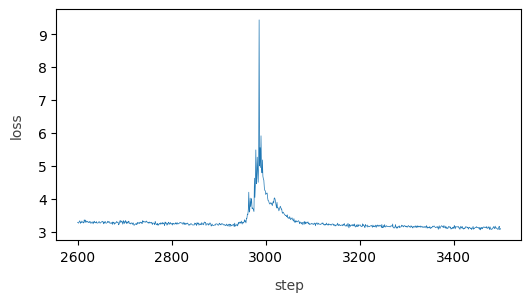

In [8]:
fp = ss_df.plot(x='step', y=['train/CrossEntropyLoss'], logy=False, linewidth=0.5, legend=False)
# _ = plt.legend(['without repetition filter'], prop={'size': 10})
fig_labels = {
    'y_label': 'loss', 
    'x_label': 'step'
}

make_standard_fig_small(fp, fig_labels=fig_labels, save=True, outfile='slowspike.pdf')

In [9]:
fs_df = builf_dir_df('adpt1srg', min_step=57500, max_step=58500)

1000it [00:00, 2027.32it/s]


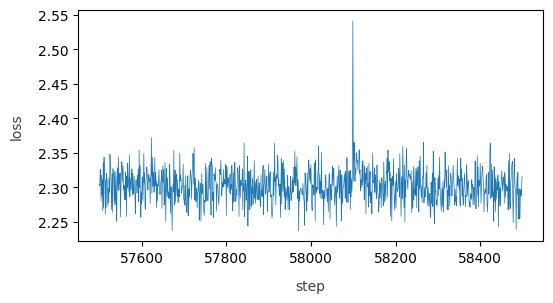

In [10]:
fp = fs_df.plot(x='step', y=['train/CrossEntropyLoss'], logy=False, linewidth=0.5, legend=False)
# _ = plt.legend(['without repetition filter'], prop={'size': 10})
fig_labels = {
    'y_label': 'loss', 
    'x_label': 'step'
}

make_standard_fig_small(fp, fig_labels=fig_labels, save=True, outfile='fastspike.pdf')

In [40]:
# runs = api.runs(f"ai2-llm/olmo-medium", filters={"group": "mitchish7"}, order="created_at")
# grad_norm_values = {}
# for run in runs:
#     for data in tqdm(run.scan_history(keys=["_step", "optim/total_grad_norm"])):
#         grad_norm_values[data["_step"]] = data["optim/total_grad_norm"]
# steps = list(grad_norm_values.keys())
# values = list(grad_norm_values.values())
# del grad_norm_values

In [12]:
res_df = pd.DataFrame({'step': steps, 'optim/total_grad_norm': values})

In [29]:
def prep_df_for_ss_1(df, start_step=None, end_step=None):
    targ_df = df.drop_duplicates('step').sort_values('step')
    targ_df.index = targ_df['step']
    return targ_df

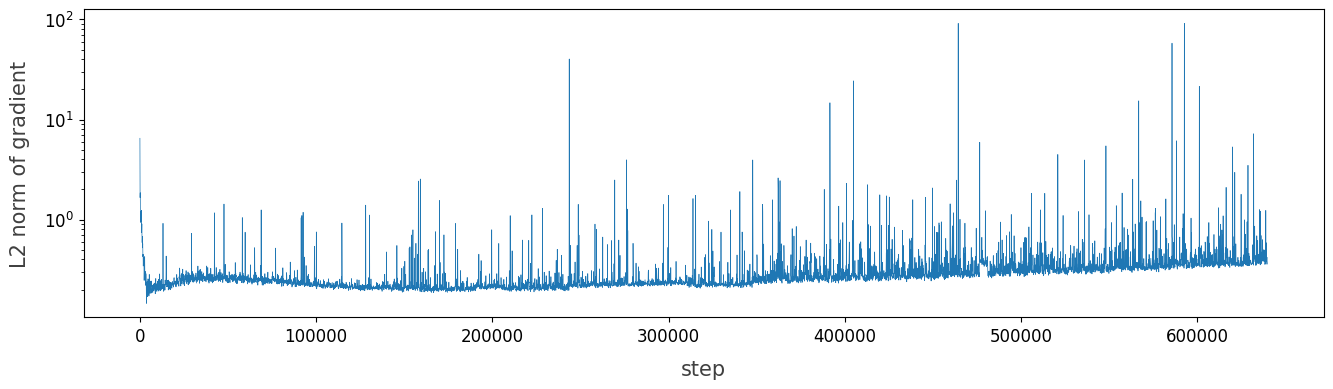

In [50]:
res_df_cleaned = prep_df_for_ss_1(res_df)
fp = res_df_cleaned[::10].plot(x='step', y=['optim/total_grad_norm'], logy=True, linewidth=0.5, legend=False, figsize=(16, 4))
# _ = plt.legend(['without repetition filter'], prop={'size': 10})
fig_labels = {
    'y_label': 'L2 norm of gradient', 
    'x_label': 'step'
}
# plt.ylim(.1, 10)
make_standard_fig(fp, fig_labels=fig_labels, save=True, outfile='mitchish7gnorm.pdf')

In [53]:
amberish_1  = build_run_df('amberish1', project="ai2-llm/olmo-small", keys=["_step", "optim/total_grad_norm", 'optim/param/transformer.wte.weight.norm'])

fetching <Run ai2-llm/olmo-small/6l9vfw5n (finished)>


149650it [00:54, 2738.20it/s]


fetching <Run ai2-llm/olmo-small/evp1r3b1 (finished)>


130260it [01:42, 1274.52it/s]


fetching <Run ai2-llm/olmo-small/btqu2w0x (finished)>


257658it [03:26, 1249.51it/s]


fetching <Run ai2-llm/olmo-small/kpvjw35y (crashed)>


48173it [02:47, 287.82it/s] 


fetching <Run ai2-llm/olmo-small/m8sj19qa (crashed)>


4750it [03:12, 24.61it/s]


fetching <Run ai2-llm/olmo-small/ekiw0rd7 (crashed)>


1403it [03:10,  7.38it/s]


fetching <Run ai2-llm/olmo-small/s5ucnsum (crashed)>


35494it [03:33, 166.48it/s] 


fetching <Run ai2-llm/olmo-small/9skkntmd (crashed)>


2385it [03:32, 11.22it/s]


fetching <Run ai2-llm/olmo-small/dxsxo2kg (crashed)>


5313it [03:29, 25.41it/s]


fetching <Run ai2-llm/olmo-small/6romq1dl (crashed)>


1270it [03:32,  5.98it/s]


fetching <Run ai2-llm/olmo-small/y5puevih (crashed)>


82048it [04:16, 320.24it/s] 


fetching <Run ai2-llm/olmo-small/pgs7fjpk (crashed)>


64it [03:18,  3.10s/it]


In [55]:
amberish_1_c2  = build_run_df('amberish1-chameleon2', project="ai2-llm/olmo-small", keys=["_step", "optim/total_grad_norm", 'optim/param/transformer.wte.weight.norm'])

fetching <Run ai2-llm/olmo-small/4hnhqvkq (finished)>


154358it [01:03, 2442.30it/s]


In [135]:
amberish_1_up_to_c2 = prep_df_for_ss(amberish_1, 0, 154357)

In [136]:
amberish_1_c2_prep = prep_df_for_ss(amberish_1_c2, 0, 154357)

In [137]:
combined_amberish1_cham_df = pd.merge(amberish_1_up_to_c2.reset_index(drop=True), amberish_1_c2_prep.reset_index(drop=True), left_on='_step', right_on='_step')

In [138]:
combined_amberish1_cham_df

,_step,optim/total_grad_norm_x,optim/param/transformer.wte.weight.norm_x,optim/total_grad_norm_y,optim/param/transformer.wte.weight.norm_y
0,1,2.395839,200.292786,5.502979,200.292648
1,2,2.413766,200.292786,5.476672,200.292648
2,3,2.392326,200.292786,5.378581,200.292648
3,4,2.417636,200.292786,5.435113,200.292648
4,5,2.483428,200.292786,5.544370,200.292648
...,...,...,...,...,...
153240,154353,0.083251,1527.012573,0.087027,1233.171997
153241,154354,0.078030,1527.016968,0.094932,1233.174072
153242,154355,0.081213,1527.021240,0.102954,1233.175903
153243,154356,0.084269,1527.025269,0.093472,1233.177856


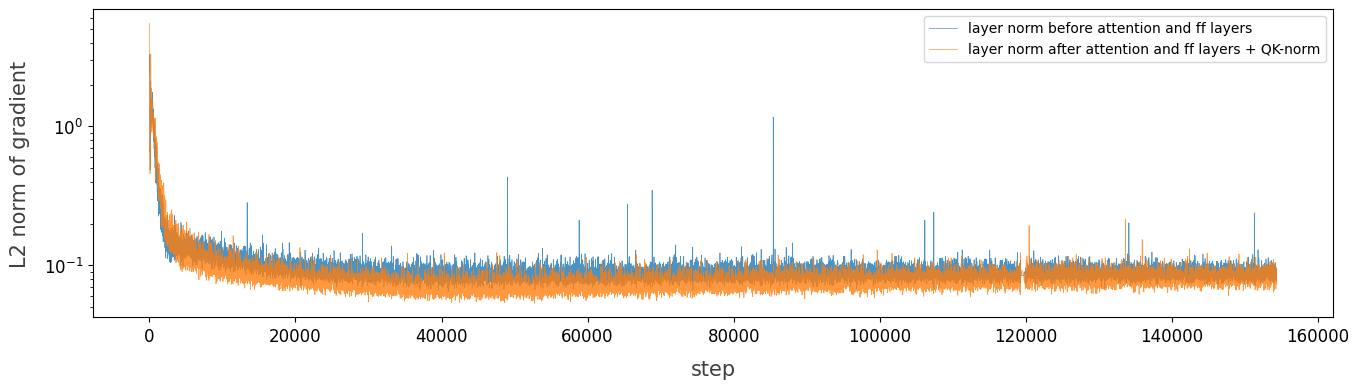

In [153]:
fp = combined_amberish1_cham_df[::10].plot(x='_step', y=['optim/total_grad_norm_x', 'optim/total_grad_norm_y'], logy=True, linewidth=0.5, alpha=0.8, figsize=(16, 4))
fig_labels = {
    'y_label': 'L2 norm of gradient', 
    'x_label': 'step'
}


_ = plt.legend(['layer norm before attention and ff layers', 'layer norm after attention and ff layers + QK-norm'], prop={'size': 10}, loc='upper right')
make_standard_fig(fp, fig_labels=fig_labels, save=True, outfile='qk_norm_reorder.pdf')

In [121]:
prep_df_for_ss(llamaish7_ndf_df, 0, 20000)

NameError: name 'llamaish7_ndf_df' is not defined

In [147]:
pre_order_norm = spike_score(amberish_1_up_to_c2, 'optim/total_grad_norm')
post_order_norm = spike_score(amberish_1_c2_prep, 'optim/total_grad_norm')

In [148]:
pre_order_norm.round(3), post_order_norm.round(3)

(0.108, 0.069)

We next tried z-loss in tandem with some other interventions suggested by the Chameleon paper, namely QK norm and applying layer norm within each block after the attention and feed-forward layers instead of before.,

Applying layer norm after the attention and feed-forward layers along with QK-norm improves stability compared to a pre-attention layer norm. These changes reduce spikescore from 0.108 to  0.069 when app.